Lid Driven Loops Solver

In [1]:
%precision 3
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sl
import scipy.sparse as sp
import scipy.sparse.linalg as spla
# the following allows us to plot triangles indicating convergence order
from matplotlib import cm
# and we will create some animations!
import matplotlib.animation as animation
from IPython.display import HTML
from pprint import pprint

In [2]:
def pressure_poisson_jacobi(p, dx, dy, RHS, rtol = 1.e-5, logs = False):
    """ Solve the pressure Poisson equation (PPE)
    using Jacobi iteration assuming mesh spacing of
    dx and dy (we assume at the moment that dx=dy)
    and the RHS function given by RHS.
    
    Assumes imposition of a Neumann BC on all boundaries.
    
    Return the pressure field.
    """
    # our code below is only currently for the case dx=dy
    assert dx==dy
    # iterate
    tol = 10.*rtol
    it = 0
    p_old = np.copy(p)
    
    imax = len(p)
    jmax = np.size(p)//imax
    
    while tol > rtol:
        it += 1
        
        for i in range(1,imax-1,1):
            for j in range(1,jmax-1,1):
                p[i, j] = 0.25*(p_old[i+1, j] + p_old[i-1, j] + p_old[i, j+1] + p_old[i,j-1] - (dx**2)*RHS[i, j])
    
        # apply zero pressure gradient Neumann boundary conditions
        for i in range(imax):
            p[i,0] = p[i,1]
            p[i,jmax-1] = p[i,jmax-2]
        for j in range(jmax):
            p[0,j] = p[1,j]
            p[imax-1,j] = p[imax-2,j]

        # fix pressure level - choose an arbitrary node to set p to
        # be zero, avoid the corners and set it to an interior location
        p[1,1] = 0

        # relative change in pressure
        tol = sl.norm(p - p_old)/np.maximum(1.0e-10,sl.norm(p))
        
        #swap arrays without copying the data
        temp = p_old
        p_old = p
        p = temp
        
    if logs: print('pressure solve iterations = {:4d}'.format(it))
    return p

In [3]:
def calculate_ppm_RHS(rho, u, v, dt, dx, dy):
    """ Calculate the RHS of the 
    Poisson equation resulting from the projection method.
    Use central differences for the first derivatives of u and v.
    """
    imax = len(p)
    jmax = np.size(p)//imax
    
    RHS = np.zeros_like(X)
    for i in range(1,imax-1,1):
        for j in range(1,jmax-1,1):
            RHS[i, j] = rho * ((1.0/dt) * ( (u[i+1, j] - u[i-1, j]) / (2*dx) + (v[i, j+1] - v[i, j-1]) / (2*dy)))
    return RHS


def project_velocity(rho, u, v, dt, dx, dy, p):
    """ Update the velocity to be divergence free using the pressure.
    """
    imax = len(p)
    jmax = np.size(p)//imax
    
    for i in range(1,imax-1,1):
        for j in range(1,jmax-1,1):
            u[i, j] = u[i, j] - dt * (1./rho) * (
                (p[i+1, j] - p[i-1, j])/(2*dx) )
            v[i, j] = v[i, j] - dt * (1./rho) * (
                (p[i, j+1] - p[i, j-1])/(2*dy) )    
    return u, v

def calculate_intermediate_velocity(nu, u, v, u_old, v_old, dt, dx, dy):
    """ Calculate the intermediate velocities.
    """
    imax = len(u)
    jmax = np.size(u)//imax
    
    for i in range(1,imax-1,1):
        for j in range(1,jmax-1,1):
            #viscous (diffusive) term first
            u[i,j] = u_old[i,j] + dt * nu * ((u_old[i+1,j]+u_old[i-1,j]-2.*u_old[i,j])/(dx**2)
                                             +(u_old[i,j+1]+u_old[i,j-1]-2.*u_old[i,j])/(dy**2))
            v[i,j] = v_old[i,j] + dt * nu * ((v_old[i+1,j]+v_old[i-1,j]-2.*v_old[i,j])/(dx**2)
                                             +(v_old[i,j+1]+v_old[i,j-1]-2.*v_old[i,j])/(dy**2))
            #add the momentum advection terms using upwinding
            if (u_old[i,j]>0.0):
                u[i,j] -= dt*(u_old[i,j]*(u_old[i,j]-u_old[i-1,j])/dx)
                v[i,j] -= dt*(u_old[i,j]*(v_old[i,j]-v_old[i-1,j])/dx)
            else:
                u[i,j] -= dt*(u_old[i,j]*(u_old[i+1,j]-u_old[i,j])/dx)
                v[i,j] -= dt*(u_old[i,j]*(v_old[i+1,j]-v_old[i,j])/dx)

            if (v_old[i,j]>0.0):
                u[i,j] -= dt*(v_old[i,j]*(u_old[i,j]-u_old[i,j-1])/dy)
                v[i,j] -= dt*(v_old[i,j]*(v_old[i,j]-v_old[i,j-1])/dy)
            else:
                u[i,j] -= dt*(v_old[i,j]*(u_old[i,j+1]-u_old[i,j])/dy)
                v[i,j] -= dt*(v_old[i,j]*(v_old[i,j+1]-v_old[i,j])/dy)
                
    return u, v

In [4]:
def solve_NS(u, v, p, rho, nu, dt, t_end, dx, dy, rtol = 1.e-5, logs = False):
    """ Solve the incompressible Navier-Stokes equations
    using a lot of the numerical choices and approaches we've seen
    earlier in this lecture.
    """
    t = 0
    
    u_old = u.copy()
    v_old = v.copy()
    
    while t < t_end:
        t += dt
        if logs: print('\nTime = {:.8f}'.format(t))

        # calculate intermediate velocities
        u, v = calculate_intermediate_velocity(nu, u, v, u_old, v_old, dt, dx, dy)
        # PPM
        # calculate RHS for the pressure Poisson problem
        p_RHS = calculate_ppm_RHS(rho, u, v, dt, dx, dy)
        # compute pressure - note that we use the previous p as an initial guess to the solution
        p = pressure_poisson_jacobi(p, dx, dy, p_RHS, 1.e-5, logs)
        # project velocity
        u, v = project_velocity(rho, u, v, dt, dx, dy, p)
        
        if logs:
            print('norm(u) = {0:.8f}, norm(v) = {1:.8f}'.format(sl.norm(u),sl.norm(v)))
            print('Courant number: {0:.8f}'.format(np.max(np.sqrt(u**2+v**2)) * dt / dx ))
        
        # relative change in u and v
        tolu = sl.norm(u - u_old)/np.maximum(1.0e-10,sl.norm(u))
        tolv = sl.norm(v - v_old)/np.maximum(1.0e-10,sl.norm(v))
        if tolu < rtol and tolv < rtol: break
            
        #swap pointers without copying data
        temp = u_old
        u_old = u
        u = temp
        temp = v_old
        v_old = v
        v = temp
    return u, v, p

In [5]:
# physical parameters
rho = 1
nu = 1./10.

# define spatial mesh
# Size of rectangular domain
Lx = 1
Ly = Lx

# Number of grid points in each direction, including boundary nodes
Nx = 51
Ny = Nx

# hence the mesh spacing
dx = Lx/(Nx-1)
dy = Ly/(Ny-1)

# read the docs to see the ordering that mgrid gives us
X, Y = np.mgrid[0:Nx:1, 0:Ny:1]
X = dx*X
Y = dy*Y
# the following is an alternative to the three lines above
#X, Y = np.mgrid[0: Lx + 1e-10: dx, 0: Ly + 1e-10: dy]
# but without the need to add a "small" increment to ensure
# the Lx and Ly end points are included

# time stepping parameters
dt = 2.e-4
t_end = 2.0

# initialise independent variables
u = np.zeros_like(X)
v = np.zeros_like(X)
p = np.zeros_like(X)

# Apply Dirichlet BCs to u and v - the code doesn't touch
# these so we can do this once outside the time loop
u[:, -1]=1  # set velocity on cavity lid equal to 1
u[:, 0]=0
u[0, :]=0
u[-1, :]=0
v[:, -1]=0
v[:, 0]=0
v[0, :]=0
v[-1, :]=0

import time
start = time.time()
u, v, p = solve_NS(u, v, p, rho, nu, dt, t_end, dx, dy, rtol=1.e-6, logs = True)
end = time.time()
print('Time taken by calculation = ', end - start)


Time = 0.00020000
pressure solve iterations = 6287
norm(u) = 7.00800116, norm(v) = 0.03434456
Courant number: 0.01000000

Time = 0.00040000
pressure solve iterations = 11647
norm(u) = 7.02817911, norm(v) = 0.08291611
Courant number: 0.01000000

Time = 0.00060000
pressure solve iterations = 5096
norm(u) = 7.05640282, norm(v) = 0.13825832
Courant number: 0.01000000

Time = 0.00080000
pressure solve iterations = 2805
norm(u) = 7.08992394, norm(v) = 0.19662819
Courant number: 0.01000000

Time = 0.00100000
pressure solve iterations = 1746
norm(u) = 7.12685793, norm(v) = 0.25592212
Courant number: 0.01000000

Time = 0.00120000
pressure solve iterations =  857
norm(u) = 7.16589599, norm(v) = 0.31489009
Courant number: 0.01000000

Time = 0.00140000
pressure solve iterations =   59
norm(u) = 7.20612155, norm(v) = 0.37280050
Courant number: 0.01000000

Time = 0.00160000
pressure solve iterations =  177
norm(u) = 7.24687941, norm(v) = 0.42942175
Courant number: 0.01000000

Time = 0.00180000
pres

In [6]:
# benchmark data from
# MARCHI, Carlos Henrique; SUERO, Roberta  and  ARAKI, Luciano Kiyoshi. 
# The lid-driven square cavity flow: numerical solution with a 
# 1024 x 1024 grid. 
# J. Braz. Soc. Mech. Sci. & Eng. 2009, vol.31, n.3, pp.186-198.  
# http://dx.doi.org/10.1590/S1678-58782009000300004.

Marchi_Re10_u = np.array([[0.0625, -3.85425800e-2],
                          [0.125,  -6.96238561e-2],
                          [0.1875, -9.6983962e-2],
                          [0.25,  -1.22721979e-1],
                          [0.3125, -1.47636199e-1],
                          [0.375,  -1.71260757e-1],
                          [0.4375, -1.91677043e-1],
                          [0.5,    -2.05164738e-1],
                          [0.5625, -2.05770198e-1],
                          [0.625,  -1.84928116e-1],
                          [0.6875, -1.313892353e-1],
                          [0.75,   -3.1879308e-2],
                          [0.8125,  1.26912095e-1],
                          [0.875,   3.54430364e-1],
                          [0.9375,  6.50529292e-1]])

Marchi_Re10_v = np.array([[0.0625, 9.2970121e-2],
                          [0.125, 1.52547843e-1],
                          [0.1875, 1.78781456e-1],
                          [0.25, 1.76415100e-1],
                          [0.3125, 1.52055820e-1],
                          [0.375, 1.121477612e-1],
                          [0.4375, 6.21048147e-2],
                          [0.5, 6.3603620e-3],
                          [0.5625, -5.10417285e-2],
                          [0.625, -1.056157259e-1],
                          [0.6875, -1.51622101e-1],
                          [0.75, -1.81633561e-1],
                          [0.8125, -1.87021651e-1],
                          [0.875, -1.59898186e-1],
                          [0.9375, -9.6409942e-2]])

Text(0.5, 1.0, 'Lid driven cavity - comparison with data')

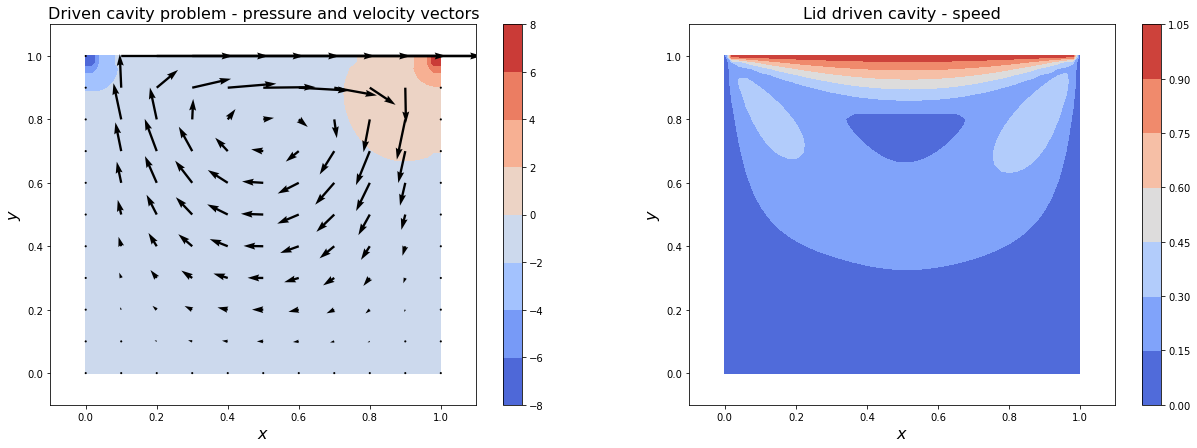

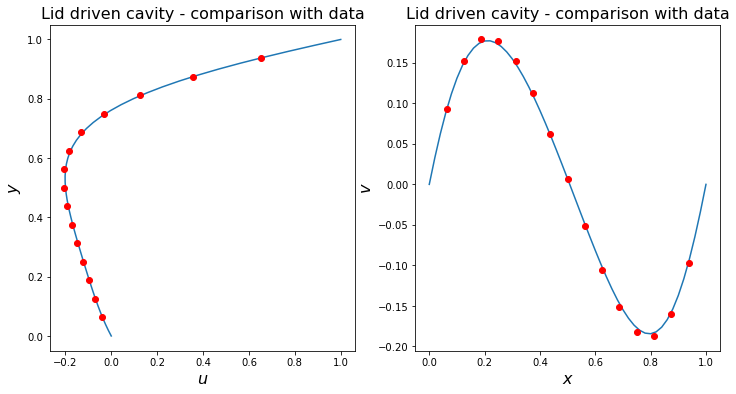

In [7]:
# set up figure
fig = plt.figure(figsize=(21, 7))
ax1 = fig.add_subplot(121)
cont = ax1.contourf(X,Y,p, cmap=cm.coolwarm)
fig.colorbar(cont)
# don't plot at every gird point - every 5th
ax1.quiver(X[::5,::5],Y[::5,::5],u[::5,::5],v[::5,::5])
ax1.set_xlim(-0.1, 1.1)
ax1.set_ylim(-0.1, 1.1)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Driven cavity problem - pressure and velocity vectors', fontsize=16)

ax1 = fig.add_subplot(122)
cont = ax1.contourf(X,Y,np.sqrt(u*u+v*v), cmap=cm.coolwarm)
fig.colorbar(cont)
ax1.set_xlim(-0.1, 1.1)
ax1.set_ylim(-0.1, 1.1)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Lid driven cavity - speed', fontsize=16)


fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax1.plot(u[np.int(np.shape(u)[0]/2),:],Y[np.int(np.shape(u)[0]/2),:])
ax1.plot(Marchi_Re10_u[:,1],Marchi_Re10_u[:,0],'ro')
ax1.set_xlabel('$u$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Lid driven cavity - comparison with data', fontsize=16)
ax1 = fig.add_subplot(122)
ax1.plot(X[:,np.int(np.shape(u)[0]/2)],v[:,np.int(np.shape(u)[0]/2)])
ax1.plot(Marchi_Re10_v[:,0],Marchi_Re10_v[:,1],'ro')
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$v$', fontsize=16)
ax1.set_title('Lid driven cavity - comparison with data', fontsize=16)